# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays
import pickle
import datetime

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import lightgbm as lgb
from lightgbm import LGBMRegressor

rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv(
    "../0_data/preprocessed/df_final_reduced.csv", try_parse_dates=True
).filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001


In [3]:
df.shape

(26304, 4)

# Missing values

Just forward fill for now.

In [4]:
df = df.fill_null(strategy="forward")

# Ensure 1 hour gaps

- and availability of full days (to walk in 24 hour steps)

In [5]:
(df["datetime"] - df["datetime"].shift(1)).value_counts()

datetime,count
duration[μs],u32
1h,26303
null,1


In [6]:
df["datetime"].min()

datetime.datetime(2021, 9, 1, 0, 0)

In [7]:
df["datetime"].max()

datetime.datetime(2024, 8, 31, 23, 0)

# Lags

## Target Variable

In [8]:
lags = (
    np.arange(0 * 24 + 1, 1 * 24 + 1).tolist()
    + np.arange(6 * 24 + 1, 7 * 24 + 1).tolist()
)
features = ["kWh"]

for feature in features:
    for lag in lags:
        df = df.with_columns(pl.col("kWh").shift(lag).alias(f"lag_{feature}_{lag}"))

In [9]:
lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168]

## Exogenous Variables

Rolling features:

- 7d average:
    - Temperature

In [10]:
rolling_features_7d = (
    df.select("datetime", "Zurich_soil_temperature_7_to_28cm")
    .with_columns(
        temp_rolling=pl.col("Zurich_soil_temperature_7_to_28cm").rolling_mean(24 * 7),
        datetime=pl.col("datetime").dt.offset_by("1d"),
    )
    .drop("Zurich_soil_temperature_7_to_28cm")
)

In [11]:
df = df.join(rolling_features_7d, how="left", on="datetime", coalesce=True)

In [12]:
(df["datetime"] - df["datetime"].shift(1)).value_counts()

datetime,count
duration[μs],u32
1h,26303
null,1


# Calendar Features

In [13]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    month=pl.col("datetime").dt.month(),
    hour=pl.col("datetime").dt.hour(),
    year=pl.col("datetime").dt.year(),
)

# Holidays

In [14]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

In [15]:
# Define holiday names
holiday_names = [
    # Osterferienzeit (Easter Holiday Season)
    "Osterferienzeit_1",
    "Osterferienzeit_2",
    "Osterferienzeit_3",
    "Osterferienzeit_4",
    "Osterferienzeit_5",
    # Auffahrtferienzeit (Ascension Holiday Season)
    "Auffahrtferienzeit_1",
    "Auffahrtferienzeit_2",
    "Auffahrtferienzeit_3",
    "Auffahrtferienzeit_4",
    "Auffahrtferienzeit_5",
]

# Repeat holiday names for each year
holiday_names_full = holiday_names * 4

# Define holiday dates
holiday_dates = [
    # 2021
    "2021-03-31",
    "2021-04-01",
    "2021-04-02",
    "2021-04-03",
    "2021-04-04",
    "2021-05-12",
    "2021-05-13",
    "2021-05-14",
    "2021-05-15",
    "2021-05-16",
    # 2022
    "2022-04-13",
    "2022-04-14",
    "2022-04-15",
    "2022-04-16",
    "2022-04-17",
    "2022-05-25",
    "2022-05-26",
    "2022-05-27",
    "2022-05-28",
    "2022-05-29",
    # 2023
    "2023-04-05",
    "2023-04-06",
    "2023-04-07",
    "2023-04-08",
    "2023-04-09",
    "2023-05-17",
    "2023-05-18",
    "2023-05-19",
    "2023-05-20",
    "2023-05-21",
    # 2024
    "2024-03-27",
    "2024-03-28",
    "2024-03-29",
    "2024-03-30",
    "2024-03-31",
    "2024-05-08",
    "2024-05-09",
    "2024-05-10",
    "2024-05-11",
    "2024-05-12",
]

# Create the DataFrame
holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": holiday_names_full,
        "holiday_date": holiday_dates,
    }
).with_columns(pl.col("holiday_date").str.to_date())

In [16]:
holiday_df = (
    pl.concat(
        [
            holiday_df,
            holiday_manual_df,
        ],
        how="vertical",
    )
    .sort("holiday_date")
    .unique("holiday_date")
)

In [17]:
holiday_df

holiday_name,holiday_date
str,date
"""Neujahrestag""",2021-01-01
"""Berchtoldstag""",2021-01-02
"""Osterferienzeit_1""",2021-03-31
"""Osterferienzeit_2""",2021-04-01
"""Karfreitag""",2021-04-02
…,…
"""Auffahrtferienzeit_5""",2024-05-12
"""Pfingstmontag""",2024-05-20
"""Nationalfeiertag""",2024-08-01


In [18]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
    .with_columns(holiday_name=pl.col("holiday_name").fill_null("no_holiday"))
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,lag_kWh_1,lag_kWh_2,lag_kWh_3,lag_kWh_4,lag_kWh_5,lag_kWh_6,lag_kWh_7,lag_kWh_8,lag_kWh_9,lag_kWh_10,lag_kWh_11,lag_kWh_12,lag_kWh_13,lag_kWh_14,lag_kWh_15,lag_kWh_16,lag_kWh_17,lag_kWh_18,lag_kWh_19,lag_kWh_20,lag_kWh_21,lag_kWh_22,lag_kWh_23,lag_kWh_24,lag_kWh_145,lag_kWh_146,lag_kWh_147,lag_kWh_148,lag_kWh_149,lag_kWh_150,lag_kWh_151,lag_kWh_152,lag_kWh_153,lag_kWh_154,lag_kWh_155,lag_kWh_156,lag_kWh_157,lag_kWh_158,lag_kWh_159,lag_kWh_160,lag_kWh_161,lag_kWh_162,lag_kWh_163,lag_kWh_164,lag_kWh_165,lag_kWh_166,lag_kWh_167,lag_kWh_168,temp_rolling,day_of_month,day_of_year,day_of_week,month,hour,year,holiday_name
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i16,i8,i8,i8,i32,str
2021-09-01 00:00:00,5.1633e6,0.0,16.042,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,244,3,9,0,2021,"""no_holiday"""
2021-09-01 01:00:00,5.0777e6,0.0,15.892,5.1633e6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,244,3,9,1,2021,"""no_holiday"""
2021-09-01 02:00:00,4.9315e6,0.0,16.042,5.0777e6,5.1633e6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,244,3,9,2,2021,"""no_holiday"""
2021-09-01 03:00:00,4.7878e6,0.0,15.942,4.9315e6,5.0777e6,5.1633e6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,244,3,9,3,2021,"""no_holiday"""
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,4.7878e6,4.9315e6,5.0777e6,5.1633e6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,244,3,9,4,2021,"""no_holiday"""


# Cyclical Encoding

In [19]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [20]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    # "day_of_week": 7,
    # "month": 12,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [21]:
cat_cols = [
    "holiday_name",
    # "day_of_month",
    # "day_of_year",
    "day_of_week",
    "month",
    # "hour",
]


num_cols = (
    df.select(
        cs.contains(
            "soil_temperature_7_to_28cm",
            "shortwave_radiation",
        )
    ).columns
    + df.select(cs.contains("lag_")).columns
    + ["year", "temp_rolling"]
)


manual_cols = df.select(pl.selectors.contains("_cos", "_sin")).columns

In [22]:
df.drop(manual_cols + cat_cols + num_cols).columns

['datetime', 'kWh']

In [23]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        #    ("scaler", StandardScaler())
    ]
)

In [24]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [25]:
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

In [26]:
preprocessor = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        (
            "variance_threshold",
            VarianceThreshold(threshold=0.0),
        ),  # Drops constant columns after transformations
    ]
)

# Hyperparameter Tuning

## Splits

Start by preprocessing the data in hourly frequency:

In [27]:
df_train = df.filter(
    (pl.col("datetime") >= pl.datetime(2021, 9, 1, 0))
    & (pl.col("datetime") <= pl.datetime(2022, 8, 31, 23))
).to_pandas()

df_val = df.filter(
    (pl.col("datetime") >= pl.datetime(2022, 9, 1, 0))
    & (pl.col("datetime") <= pl.datetime(2023, 8, 31, 23))
).to_pandas()

In [28]:
X_train = df_train.drop(columns=["datetime", "kWh"])
X_val = df_val.drop(columns=["datetime", "kWh"])

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [29]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_train),
    columns=fitted_preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_val),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [30]:
df_train_preprocessed = pd.concat(
    [df_train.filter(["datetime", "kWh"]), X_train_preprocessed], axis=1
)

df_val_preprocessed = pd.concat(
    [df_val.filter(["datetime", "kWh"]), X_val_preprocessed], axis=1
)

In [31]:
df_trainval = pd.concat(
    [df_train_preprocessed, df_val_preprocessed], axis=0
).reset_index(drop=True)


df_trainval.shape

(17520, 98)

In [32]:
(df_trainval["datetime"] - df_trainval["datetime"].shift(1)).value_counts()

datetime
0 days 01:00:00    17519
Name: count, dtype: int64

## Manual test

In [33]:
model = LGBMRegressor()
model = model.fit(X_train_preprocessed, y_train)

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 96
[LightGBM] [Info] Start training from score 6469662.881707


Write the validation loop that does recursive forecasting:

In [34]:
def recursive_validation(model, X_val, step_size, verbose=False):

    validation_data = X_val.copy()
    lag_columns = [f"numeric__lag_kWh_{i}" for i in range(1, step_size + 1)]
    predictions = []
    step_size = 24

    progress_bar = tqdm(
        np.arange(0, validation_data.shape[0], step_size), disable=not verbose
    )

    for origin in progress_bar:

        # Get copy of next window
        window_features = validation_data.copy().iloc[origin : origin + step_size]
        window_preds = []

        for h in range(step_size):
            # Identify next hour to predict on
            hour_features = window_features.iloc[[h]].copy()

            # Identify which lags to replace by predictions
            # example: h=2 is third hour -> need to replace h=0 and h=1
            # which are lag1 and lag2
            affected_colnames = [lag_columns[x] for x in np.arange(0, h)]

            # Change actuals to predictions for affected lags
            if affected_colnames:
                hour_features.loc[:, affected_colnames] = window_preds[::-1]

            window_preds.append(model.predict(hour_features)[0])

            # if h == 23:
            #     break

        predictions.extend(window_preds)

    return predictions

In [35]:
val_preds = pd.DataFrame(
    {
        "datetime": df_val_preprocessed["datetime"],
        "pred": recursive_validation(model, X_val_preprocessed, 24, verbose=True),
        "kWh": y_val,
    }
)

  0%|          | 0/365 [00:00<?, ?it/s]

In [36]:
loss = root_mean_squared_error(y_pred=val_preds["pred"], y_true=val_preds["kWh"])
loss

268629.185798961

In [37]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    val_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Validation Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [37]:
# Need to account for the edge case of missing historical data at the start:
# Remove the first l observations from the datetime col that haven't been used
train_preds = pd.DataFrame(
    {
        "datetime": df_train_preprocessed["datetime"],
        "pred": model.predict(X_train_preprocessed),
        "kWh": y_train,
    }
)


# Create the figure with step lines for both actual and predicted values
fig = px.line(
    train_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Training Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

## RayTune Tuning Loop

In [ ]:
# Define LightGBM training function
def lightgbm_trainable(config):

    model = LGBMRegressor(
        n_estimators=config["n_estimators"],
        learning_rate=config["learning_rate"],
        num_leaves=config["num_leaves"],
        subsample=config["subsample"],
        reg_alpha=config["reg_alpha"],
        reg_lambda=config["reg_lambda"],
        random_state=42,
    )
    model.fit(X_train_preprocessed, y_train)

    # Use the recursive validation function to make predictions
    val_preds = pd.DataFrame(
        {
            "datetime": df_val_preprocessed["datetime"],
            "pred": recursive_validation(
                model, X_val_preprocessed, step_size=24, verbose=False
            ),
            "kWh": y_val,
        }
    )

    # Compute the loss (RMSE) on validation set
    loss = root_mean_squared_error(y_true=val_preds["kWh"], y_pred=val_preds["pred"])

    # Report the validation loss to RayTune
    train.report({"loss": loss})

In [ ]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    lightgbm_trainable,
    config={
        # Control complexity
        "num_leaves": tune.randint(10, 100),
        # Regularization against over-fitting
        "learning_rate": tune.loguniform(1e-6, 0.5),
        # General boosting hyperparameters
        "n_estimators": tune.randint(20, 800),  # Number of boosting rounds
        "subsample": tune.uniform(0.5, 1.0),  # Subsample ratio for data
        "reg_alpha": tune.uniform(0, 100),  # L1 regularization
        "reg_lambda": tune.uniform(0, 100),  # L2 regularization
    },
    metric="loss",
    mode="min",
    name="LGBM",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 0.5,
    num_samples=-1,
    max_concurrent_trials=8,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

In [ ]:
analysis.dataframe().to_csv("08_LGBM_trials.csv", index=False)

# Validation Performance of the Best Model

In [ ]:
trials_df = pl.read_csv("08_LGBM_trials.csv")
trials_df.shape

(195, 21)

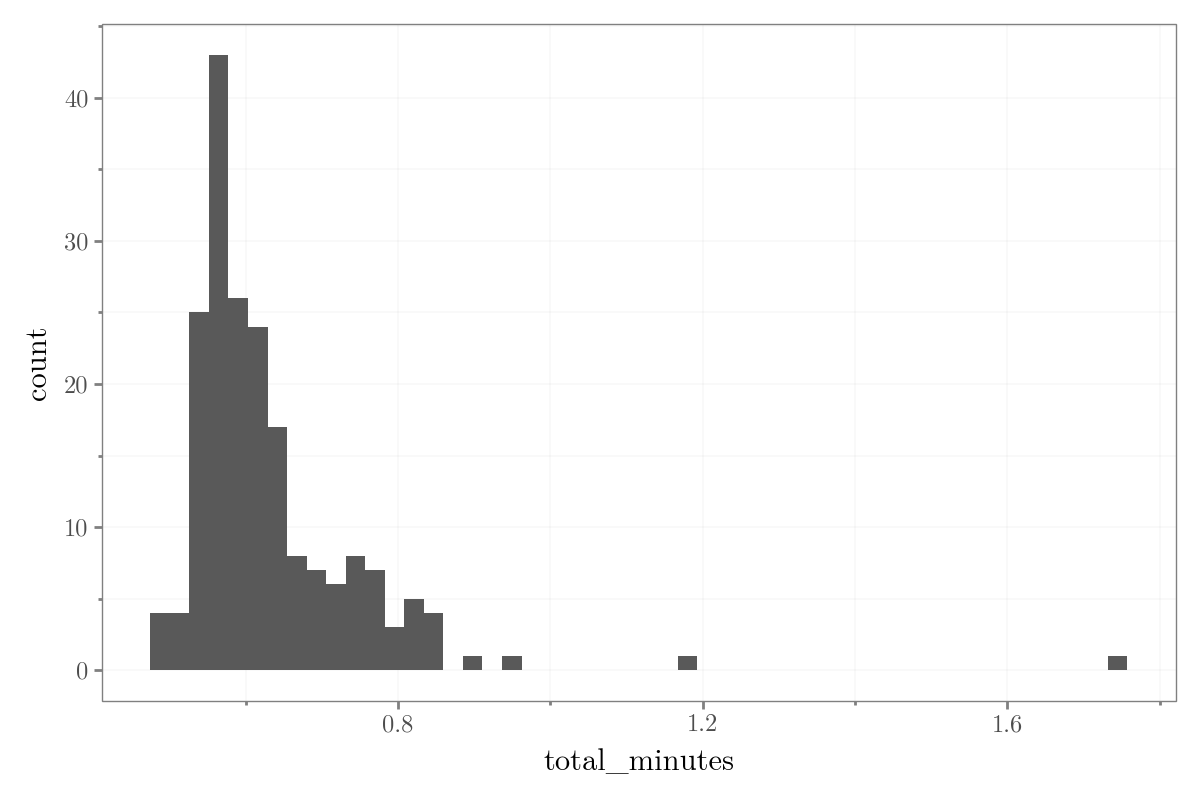

In [39]:
(
    pn.ggplot(
        data=(trials_df.with_columns(total_minutes=pl.col("time_total_s") / 60)),
        mapping=pn.aes("total_minutes"),
    )
    + pn.geom_histogram(bins=50)
    + theme_academic
)

In [40]:
# Aggregate trials by average to lose the noise
trials_df = (
    trials_df.group_by(pl.selectors.contains("config/"))
    .agg(loss=pl.mean("loss"), count=pl.len())
    .sort("loss")
)

trials_df.head()

config/num_leaves,config/learning_rate,config/n_estimators,config/subsample,config/reg_alpha,config/reg_lambda,loss,count
i64,f64,i64,f64,f64,f64,f64,u32
10,0.11981,557,0.63099,98.391206,17.02285,239448.837537,1
10,0.151874,604,0.523626,99.868912,33.127787,239877.845909,1
10,0.119369,684,0.643854,93.825703,16.890185,242287.266795,1
12,0.101301,723,0.613109,92.192769,21.614993,242488.225896,1
10,0.121196,569,0.624039,94.409649,32.662754,243723.134187,1


In [41]:
selected_trial = trials_df.sort("loss").head(1)
best_hyperparams_df = (
    selected_trial.select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(pl.col("variable").str.replace("config/", ""))
)
# Make dictionary (all strings)
best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)
# Convert strings to correct data types
converted_params = {
    "num_leaves": int(best_hyperparams["num_leaves"]),
    "learning_rate": float(best_hyperparams["learning_rate"]),
    "n_estimators": int(best_hyperparams["n_estimators"]),
    "subsample": float(best_hyperparams["subsample"]),
    "reg_alpha": float(best_hyperparams["reg_alpha"]),
    "reg_lambda": float(best_hyperparams["reg_lambda"]),
}

converted_params

{'num_leaves': 10,
 'learning_rate': 0.11981014668378244,
 'n_estimators': 557,
 'subsample': 0.6309895843607461,
 'reg_alpha': 98.39120606390959,
 'reg_lambda': 17.022850061491354}

In [42]:
selected_trial["loss"]

loss
f64
239448.837537


In [43]:
model = LGBMRegressor(
    n_estimators=converted_params["n_estimators"],
    learning_rate=converted_params["learning_rate"],
    num_leaves=converted_params["num_leaves"],
    subsample=converted_params["subsample"],
    reg_alpha=converted_params["reg_alpha"],
    reg_lambda=converted_params["reg_lambda"],
    random_state=42,
)
model = model.fit(X_train_preprocessed, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 96
[LightGBM] [Info] Start training from score 6469662.881707


In [44]:
val_preds = pd.DataFrame(
    {
        "datetime": df_val_preprocessed["datetime"],
        "pred": recursive_validation(
            model, X_val_preprocessed, step_size=24, verbose=True
        ),
        "kWh": y_val,
    }
)

  0%|          | 0/365 [00:00<?, ?it/s]

In [45]:
loss = root_mean_squared_error(y_true=val_preds["kWh"], y_pred=val_preds["pred"])
loss

239448.83753741797

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    val_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Validation Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [ ]:
# Need to account for the edge case of missing historical data at the start:
# Remove the first l observations from the datetime col that haven't been used
train_preds = pd.DataFrame(
    {
        "datetime": df_train_preprocessed["datetime"],
        "pred": recursive_validation(
            model, X_train_preprocessed, step_size=24, verbose=True
        ),
        "kWh": y_train,
    }
)


# Create the figure with step lines for both actual and predicted values
fig = px.line(
    train_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Training Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Model Evaluation without Retraining

Evaluate on the holdout period by retraining with the  best_hyperparams chosen from tuning on validation set.

- Train once: on the entire training + validation period, but WITHOUT early stopping, pick the exact number of epochs to train for and train on the full training data set
    - Restore the best weights on the training set? Or just go with it

## Splits

Start by preprocessing the data in hourly frequency:

In [ ]:
df_train = df.filter(
    (pl.col("datetime") >= pl.datetime(2021, 9, 1, 0))
    & (pl.col("datetime") <= pl.datetime(2023, 8, 31, 23))
).to_pandas()

df_test = df.filter(pl.col("datetime") >= pl.datetime(2023, 9, 1, 0)).to_pandas()

In [ ]:
X_train = df_train.drop(columns=["datetime", "kWh"])
X_test = df_test.drop(columns=["datetime", "kWh"])

y_train = df_train["kWh"]
y_test = df_test["kWh"]

In [ ]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_train),
    columns=fitted_preprocessor.get_feature_names_out(),
)

X_test_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_test),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [ ]:
df_train_preprocessed = pd.concat(
    [df_train.filter(["datetime", "kWh"]), X_train_preprocessed], axis=1
)

df_test_preprocessed = pd.concat(
    [df_test.filter(["datetime", "kWh"]), X_test_preprocessed], axis=1
)

In [ ]:
df_traintest = pd.concat(
    [df_train_preprocessed, df_test_preprocessed], axis=0
).reset_index(drop=True)

df_traintest.shape

In [ ]:
(df_traintest["datetime"] - df_traintest["datetime"].shift(1)).value_counts()

## Fit

Here, I can't use early stopping as it would be considered data leakage. Need to blindly train on the training set (train + val) for the number of epochs that seems appropriate from the validation fit.

max_epochs: Check the shape of the validation fit (train/val curves) and decide number of epochs to train for based on overfit.

In [ ]:
model = LGBMRegressor(
    n_estimators=converted_params["n_estimators"],
    learning_rate=converted_params["learning_rate"],
    num_leaves=converted_params["num_leaves"],
    subsample=converted_params["subsample"],
    reg_alpha=converted_params["reg_alpha"],
    reg_lambda=converted_params["reg_lambda"],
    random_state=42,
)
model = model.fit(X_train_preprocessed, y_train)

In [ ]:
holdout_preds = pd.DataFrame(
    {
        "datetime": df_test_preprocessed["datetime"],
        "pred": recursive_validation(
            model, X_test_preprocessed, step_size=24, verbose=True
        ),
        "kWh": y_test,
    }
)

In [ ]:
holdout_preds.to_csv("08_LGBM_holdout_predictions_no_retraining.csv", index=False)

In [ ]:
loss = root_mean_squared_error(
    y_pred=holdout_preds["pred"], y_true=holdout_preds["kWh"]
)
loss

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    holdout_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Holdout Fit without Retraining",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Model Evaluation with Retraining

Evaluate on the holdout period by retraining with the best_hyperparams chosen from tuning on validation set.

- Retrain weekly: on the entire training + validation period, but WITHOUT early stopping, pick the exact number of epochs to train for and train on the full training data set
    - Restore the best weights on the training set? Or just go with it
- Add the new week of observations in each step as training data (sliding window) and remove the oldest week

In [ ]:
X_traintest_preprocessed = pd.concat(
    [X_train_preprocessed, X_test_preprocessed], axis=0
)

y_traintest = pd.concat([y_train, y_test], axis=0)

In [ ]:
# Daily frequency data: Retrain each week while retaining the old data
max_history = 365 * 24 * 2
retrain_freq = 7 * 24

retrain_points = np.arange(
    X_train_preprocessed.shape[0],
    X_traintest_preprocessed.shape[0],
    retrain_freq,
)

retrain_points

In [ ]:
# The year is not a perfect 52 weeks, 2 days are extra, need to
# be careful with the slicers build in a safety
X_traintest_preprocessed.shape[0] - retrain_points[-1]

In [ ]:
holdout_pred_dfs = []

# Split point denotes where df is broken into history (2 years max)
# and test period (1 week, then move one week ahead and retrain)
for split_point in tqdm(retrain_points):

    # Get the training and test period for the current "viewpoint week"
    X_train_sliced = X_traintest_preprocessed[
        np.amax([0, split_point - max_history]) : split_point
    ]
    X_test_sliced = X_traintest_preprocessed[
        split_point : np.amin(
            [split_point + retrain_freq, X_traintest_preprocessed.shape[0]]
        )
    ]

    y_train_sliced = y_traintest[np.amax([0, split_point - max_history]) : split_point]
    y_test_sliced = y_traintest[
        split_point : np.amin(
            [split_point + retrain_freq, X_traintest_preprocessed.shape[0]]
        )
    ]

    # Fit model
    model = LGBMRegressor(
        n_estimators=converted_params["n_estimators"],
        learning_rate=converted_params["learning_rate"],
        num_leaves=converted_params["num_leaves"],
        subsample=converted_params["subsample"],
        reg_alpha=converted_params["reg_alpha"],
        reg_lambda=converted_params["reg_lambda"],
        random_state=42,
    )
    model = model.fit(X_train_sliced, y_train_sliced)

    # Make predictions on holdout week
    y_preds_holdout = pd.DataFrame(
        {
            "pred": recursive_validation(
                model, X_test_sliced, step_size=24, verbose=False
            ),
            "kWh": y_test_sliced,
        }
    )
    holdout_pred_dfs.append(y_preds_holdout)

In [ ]:
y_preds_holdout = (
    pd.concat(holdout_pred_dfs, axis=0)
    .reset_index(drop=True)
    .assign(datetime=lambda x: df_test["datetime"])
)

y_preds_holdout.head()

In [ ]:
y_preds_holdout.to_csv("08_LGBM_holdout_predictions_with_retraining.csv", index=False)

In [ ]:
loss = root_mean_squared_error(
    y_pred=y_preds_holdout["pred"], y_true=y_preds_holdout["kWh"]
)
loss

In [ ]:
fig = px.line(
    y_preds_holdout,
    x="datetime",
    y=["pred", "kWh"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Holdout Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

fig.show()

# Variable Importance

Use leave-one-out variable importance in the validation split as a measure of variable importance

## Splits

Start by preprocessing the data in hourly frequency:

In [38]:
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance

In [39]:
df_trainval = df.filter(pl.col("datetime") <= pl.datetime(2024, 8, 31, 23))

In [40]:
X_train = df_trainval.to_pandas().drop(columns=["datetime", "kWh"])
y_train = df_trainval.to_pandas()["kWh"]

In [41]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_train),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [44]:
df_train_preprocessed = pd.concat(
    [df_trainval.to_pandas().filter(["datetime", "kWh"]), X_train_preprocessed], axis=1
)

In [45]:
# define the validation scheme
cv = KFold(n_splits=4, shuffle=False)

In [46]:
# define the binary target and the features
dataset = Dataset(
    df=df_train_preprocessed,
    target="kWh",
    features=df_train_preprocessed.drop(columns=["kWh", "datetime"]).columns.tolist(),
)

In [47]:
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_root_mean_squared_error")

In [48]:
importance_df = lofo_imp.get_importance()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13663
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 78
[LightGBM] [Info] Start training from score 6019824.465214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13644
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 78
[LightGBM] [Info] Start training from score 6192573.702821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13663
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 78
[LightGBM] [

  0%|          | 0/96 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13663
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 78
[LightGBM] [Info] Start training from score 6019824.465214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13644
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 78
[LightGBM] [Info] Start training from score 6192573.702821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13663
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 78
[LightGBM] [

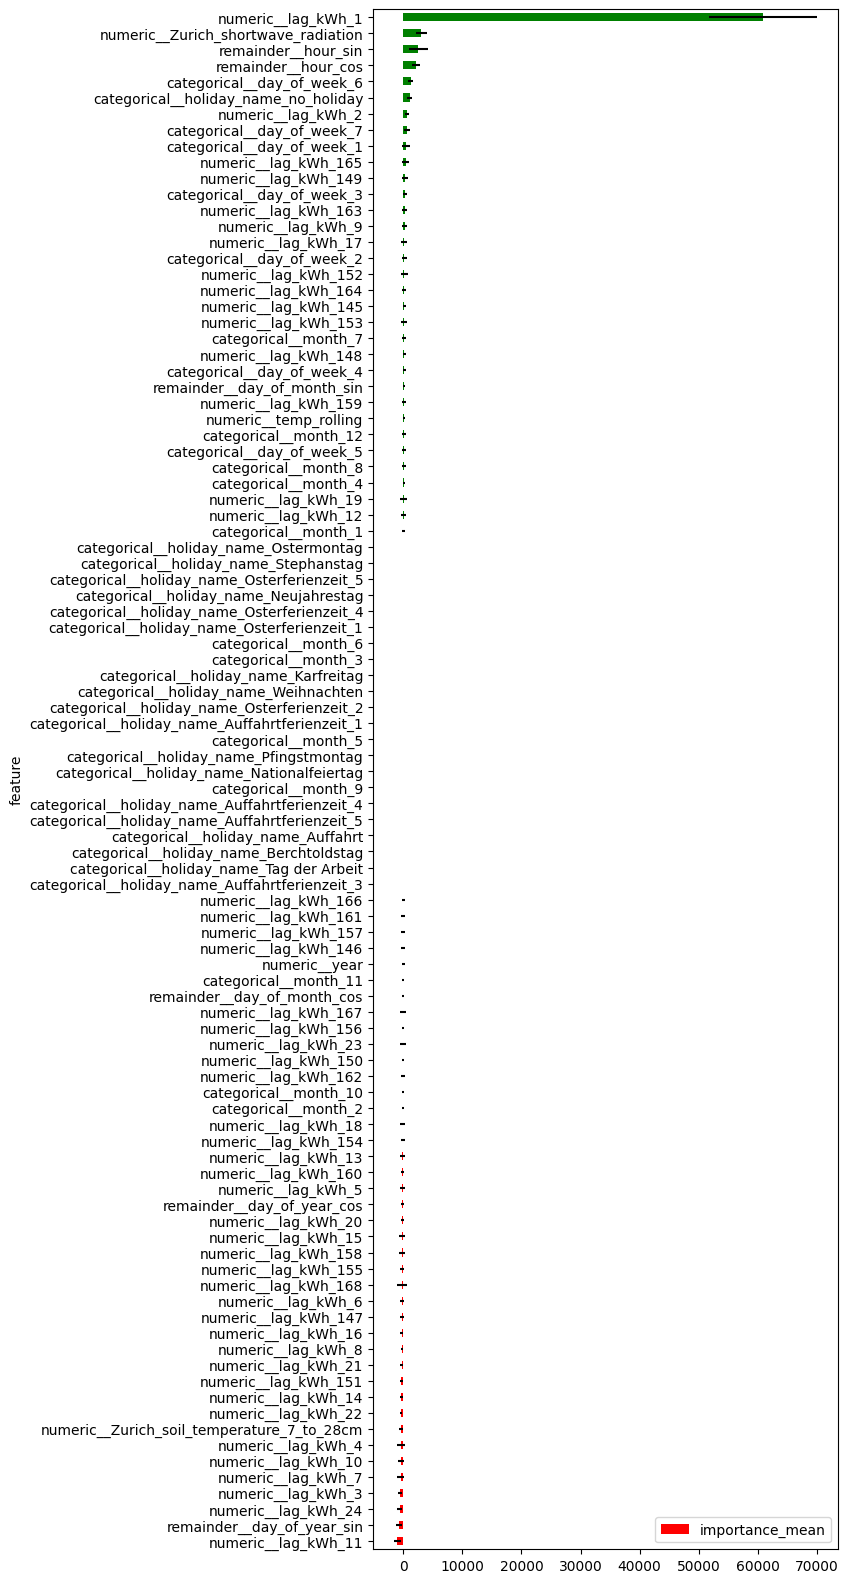

In [49]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(6, 20))